In [1]:
import math
from langdetect import detect,detect_langs

import pandas as pd
import numpy as np
import os
import email
import email.policy
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import RegexpTokenizer,word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from string import punctuation
#from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re
import heapq

import matplotlib.pyplot as plt

In [2]:
os.listdir('./Database')

['ham', 'spam']

In [3]:
arquivosNormais = [nomeArquivo for nomeArquivo in (os.listdir("./Database/ham")) if len(nomeArquivo) > 20]
arquivosSpam = [nomeArquivo for nomeArquivo in (os.listdir("./Database/spam")) if len(nomeArquivo) > 20]

In [4]:
secondaryDatabaseOnlySpam = pd.read_csv('onlySpam.csv',delimiter=',').drop(columns=["Unnamed: 0"])

arquivosSpamSecondary = [f"spam{i+len(arquivosSpam)}" for i in range(len(secondaryDatabaseOnlySpam))]

In [5]:
def carregarEmail(tipo, arquivo):
    caminho = ""

    if tipo == "spam":
        caminho = "./Database/spam"
    if tipo == "ham":
        caminho = "./Database/ham"

    with open(f"{caminho}/{arquivo}", "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)


emailsNormais = [carregarEmail("ham", arquivo) for arquivo in arquivosNormais]
emailsSpam = [carregarEmail("spam", arquivo) for arquivo in arquivosSpam]

In [6]:
for i in range(len(arquivosNormais)):
    arquivosNormais[i] = f"ham{i}"

for i in range(len(arquivosSpam)):
    arquivosSpam[i] = f"spam{i}"

emailsNome = arquivosNormais + arquivosSpam

emailsNome += arquivosSpamSecondary

In [7]:
emails = emailsNormais + emailsSpam

aux = emailsNormais[0]

In [8]:
for i in aux.keys():
    print(f"{i} : {aux[i]}")

print('\n')
print('Conteudo:', aux.get_content())

Return-Path : <exmh-workers-admin@example.com>
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 

In [9]:
def get_email_structure(email):
    if isinstance(email, str):
        return email

    payload = email.get_payload()

    if isinstance(payload, list):
        lista = []
        for sub_email in payload:
            lista.append(get_email_structure(sub_email))

        return "Estruturas do email:", lista

    else:

        return email.get_content_type()


emailsNormaisMultipart = get_email_structure(emailsNormais[634])

In [10]:
emailsNormaisMultipart

('Estruturas do email:', ['text/plain', 'text/html'])

In [11]:

for email in emailsNormais[634].walk():
    print(email)

Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id C2C2316F16
	for <jm@localhost>; Fri, 13 Sep 2002 13:37:26 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Fri, 13 Sep 2002 13:37:26 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g8CNsQC20509 for <jm@jmason.org>;
    Fri, 13 Sep 2002 00:54:27 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id A31B02940D3; Thu, 12 Sep 2002 16:51:04 -0700 (PDT)
Delivered-To: fork@example.com
Received: from web13003.mail.yahoo.com (web13003.mail.yahoo.com
    [216.136.174.13]) by xent.com (Postfix) with SMTP id 5696629409A for
    <fork@xent.com>; Thu, 12 Sep 2002 16:50:13 -0700 (PDT)
Message-Id: <20020912235313.4003.qmail@web13003.mail.yahoo.com>
Received: from

In [12]:
def html_to_text(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n', '')
    except:
        return "empty"


def email_to_text(email):
    for emailParts in email.walk():
        if emailParts.get_content_type() not in ['text/plain', 'text/html']:
            continue

        try:
            emailPartsContent = emailParts.get_content()
        except:
            emailPartsContent = str(emailParts.get_payload())

        if emailParts.get_content_type() == 'text/plain':
            return emailPartsContent
        else:
            return html_to_text(emailParts)


'''def email_to_text(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_text(part)'''


"def email_to_text(email):\n    struct = get_email_structure(email)\n    for part in email.walk():\n        partContentType = part.get_content_type()\n        if partContentType not in ['text/plain','text/html']:\n            continue\n        try:\n            partContent = part.get_content()\n        except: # in case of encoding issues\n            partContent = str(part.get_payload())\n        if partContentType == 'text/plain':\n            return partContent\n        else:\n            return html_to_text(part)"

In [13]:
email_to_text(emailsNormais[0])

'    Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\n18:19:04 Ftoc_PickMsgs {{1 hit}}\n18:19:04 Marking 1 hits\n18:19:04 tkerror: syntax error in expression "int ...\n\nNote, if I run the pick command by hand ...\n\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\n1 hit\n\nThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m\nusing is ...\n\ndelta$ pick -version\npick -- nmh-1.0.4 [compiled on fuchsia.c

In [14]:

import validators

def removePunctuation(text):
    ponctuation = list(punctuation)

    for i in ponctuation:
        text = text.replace(i, "")

    return text


def wordsPreProcessing(email):
    if email is None:
        return 'empty'

    newText = ""

    stopWords = set(stopwords.words('english')  + list(punctuation))
    stopWords.add("subject")
    stem = PorterStemmer()
    wordTokenize = RegexpTokenizer(r'\w+')

    regex = re.compile(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+')

    e = email.split()

    for i in range(0,len(e)):
        if validators.url(e[i]):
            e[i] = "URLLL"

        if re.fullmatch(regex,e[i]):
            e[i] = "EMAILLL"


    for text in word_tokenize(" ".join(e).lower()):
        #print(text)
        text = removePunctuation(text)
        if text not in stopWords and not text.isdigit():

            newText += stem.stem(text) + " "

    return newText

In [15]:
print(wordsPreProcessing(email_to_text(emails[0])))
print(email_to_text(emails[0]))

date  wed  aug  chri garrigu  cwgdated103037728706fa6d  deepeddycom  messageid   10299452874797tmda  deepeddyvirciocom   ca nt reproduc error  repeat   like everi time  without fail   debug log pick happen  pickit  exec pick inbox list lbrace lbrace ftp rbrace rbrace   sequenc mercuri  exec pick inbox list lbrace lbrace ftp rbrace rbrace sequenc mercuri ftocpickmsg   hit   mark hit tkerror  syntax error express  int  note  run pick command hand  delta  pick inbox list lbrace lbrace ftp rbrace rbrace sequenc mercuri hit  hit  come  obvious   version nmh use  delta  pick version pick  nmh104  compil fuchsiacsmuozau sun mar ict  relev part mhprofil  delta  mhparam pick seq sel list sinc pick command work  sequenc  actual   one explicit command line  search popup  one come mhprofil  get creat  kre ps  still use version code form day ago  nt abl reach cv repositori today  local rout issu think    exmhwork mail list emaill urlll 
    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:    

In [16]:
def bagOfWord(emails):
    wordCount = {}

    for email in emails:
        for i in email.split():
            if i not in wordCount.keys():
                wordCount[i] = 1
            else:
                wordCount[i] += 1

    return wordCount

In [17]:
emailsText = []

for email in emails:
    emailsText.append(wordsPreProcessing
                      (email_to_text(email)))

for email in secondaryDatabaseOnlySpam["text"].array:
    emailsText.append(wordsPreProcessing(email))

print(emailsText[4000])


 imageplu  ink  toner ribbon cartridg laser  ink ribbon cartridg p e c l imag plu laser toner ink cartridg ribbon paper ink cartridg one year warranti iso certifi made canada  v e upto  without compromis qualiti   note  imagepluscartridg refil  butnewcartridg   call complet list product laser cartridgesfor hp ink cartridgesfor hp ink cartridgesfor epson ink cartridgesfor canon ribbonsfor epson c x   c     bci b     c   c     bci c     c   c     bci b     c   c     bci c     c   c     bci e bl   sol   c x   c     bci e cy   sol   c   cl     bci e   sol   c   c     bci e ye   c   c     bx   c   c     bc    c   c     bc    c   c     bji   contact quantiti discount enquiri pleas contact  sale  imageplu   com tel  price u   dollar  ex  work  fax  jebel ali duti free zone www  imageplu   com price avail chang usa  canada  u   e  without notic  receiv special offer plain text format repli mail request email consid spam long includ  contact inform remov instruct  messag intend dealer resel  so

In [17]:
wordCount = bagOfWord(emailsText)

wordFrequency = heapq.nlargest(100, wordCount, wordCount.get)

print(wordFrequency)

NameError: name 'bagOfWord' is not defined

In [127]:
tfidfVectorizer = TfidfVectorizer(analyzer="word",max_features=2100)
#tfidfVectorizer = TfidfVectorizer(analyzer="word")

tfidfTransform = tfidfVectorizer.fit_transform(emailsText)

print(tfidfTransform)

  (0, 1967)	0.02580287188362771
  (0, 595)	0.037851883527718365
  (0, 1116)	0.0354135965622576
  (0, 673)	0.08190020843717173
  (0, 1875)	0.04664275901904373
  (0, 995)	0.058900175037022606
  (0, 1601)	0.09188450055298315
  (0, 1092)	0.06597187866177635
  (0, 1896)	0.05021520586948872
  (0, 1554)	0.08700530254797344
  (0, 446)	0.0764885906048749
  (0, 1502)	0.06821618325137999
  (0, 1)	0.0636059722041825
  (0, 46)	0.06559723226485141
  (0, 459)	0.04856302031577669
  (0, 762)	0.056183582187941006
  (0, 337)	0.05797685395467834
  (0, 1784)	0.05062345672791785
  (0, 1470)	0.08136778860988461
  (0, 437)	0.06141856929239886
  (0, 806)	0.032857584070843694
  (0, 1636)	0.06655178650331323
  (0, 1081)	0.05122128826695178
  (0, 1282)	0.07233177424056172
  (0, 19)	0.05440205819182799
  :	:
  (4550, 378)	0.0751244001465824
  (4550, 1441)	0.051424824007810024
  (4550, 1870)	0.05019693669403803
  (4550, 1234)	0.04392222350369823
  (4550, 1571)	0.05778032762614838
  (4550, 900)	0.06572814932970314
 

In [130]:
tfidfLabels = tfidfVectorizer.get_feature_names()
tfidfLabels

['abil',
 'abl',
 'absolut',
 'abus',
 'acceler',
 'accept',
 'access',
 'accord',
 'account',
 'accur',
 'accuraci',
 'achiev',
 'acknowledg',
 'acquir',
 'acquisit',
 'across',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'adam',
 'adapt',
 'add',
 'addit',
 'address',
 'administr',
 'adob',
 'adopt',
 'adult',
 'advanc',
 'advantag',
 'advertis',
 'advic',
 'advis',
 'advisor',
 'affair',
 'affect',
 'affili',
 'afford',
 'africa',
 'african',
 'age',
 'agenc',
 'agent',
 'aggress',
 'ago',
 'agre',
 'agreeabl',
 'agreement',
 'ah',
 'aid',
 'aim',
 'air',
 'al',
 'alb',
 'alcohol',
 'alert',
 'ali',
 'align',
 'alli',
 'allianc',
 'allow',
 'almost',
 'alon',
 'along',
 'alreadi',
 'alsa',
 'also',
 'alt',
 'altern',
 'although',
 'alway',
 'amaz',
 'amend',
 'america',
 'american',
 'among',
 'amount',
 'analog',
 'analysi',
 'analyst',
 'angel',
 'angl',
 'anim',
 'announc',
 'annoy',
 'annual',
 'anonym',
 'anoth',
 'answer',
 'anthoni',
 'anticip',
 'antiqu',
 'anybodi',
 'a

In [131]:
dfTfidfArray = pd.DataFrame(data=tfidfTransform.toarray(), index=emailsNome, columns=tfidfLabels)

In [133]:
dfTfidfArray

ok


In [30]:
arrayTargetsNormais = [0 for _ in arquivosNormais]

arrayTargetsSpam = [1 for _ in range(len(arquivosSpam)+len(arquivosSpamSecondary))]

targetsArray = arrayTargetsNormais + arrayTargetsSpam

print(len(targetsArray))
print(targetsArray)

4551
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [137]:
dfTfidfArray.insert(len(dfTfidfArray.columns), "Target", targetsArray, True)
dfTfidfArray = dfTfidfArray.sample(frac=1)
dfTfidfArray


,abil,abl,absolut,abus,acceler,accept,access,accord,account,accur,...,yeah,year,yesterday,yet,york,young,zero,zone,Target,Target
spam1225,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,1,1
ham775,0.0,0.032956,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.000000,0.024766,0.040459,0.00000,0.040243,0.0,0.0,0.000000,0,0
spam651,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.000000,0.073780,0.000000,0.00000,0.000000,0.0,0.0,0.000000,1,1
spam1557,0.0,0.000000,0.0,0.0,0.0,0.017787,0.0,0.04073,0.0,0.0,...,0.000000,0.013585,0.000000,0.01783,0.000000,0.0,0.0,0.000000,1,1
spam1689,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.051736,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ham2205,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0,1
ham346,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.098229,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0,0
ham2158,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0,1
ham2008,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0,0


In [25]:
#dfTfidfArray.to_csv("dataset.csv", sep='\t', encoding='utf-8')

C:\Users\Renato Vidal\.conda\envs\ox\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Renato Vidal\.conda\envs\ox\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


              0          1  Target
0     17.789520  20.573011       1
1    -64.891914  12.949758       0
2    -28.408066 -48.308514       0
3    -44.256176  35.524593       0
4    -39.034599   0.745447       0
...         ...        ...     ...
4546 -52.820938 -33.834179       0
4547  27.279127  15.527202       1
4548  10.995664  18.914606       1
4549   8.778528  -8.025466       1
4550  48.917480   5.095499       1

[4551 rows x 3 columns]


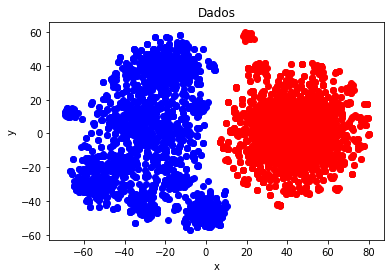

In [26]:
model = TSNE(n_components=2, random_state=0)
#model = PCA(n_components=50, svd_solver='full')
array_red = model.fit_transform(dfTfidfArray)

df_tsne = pd.DataFrame(array_red)

target = dfTfidfArray["Target"].array

df_tsne['Target'] = target
print(df_tsne)
df_tsne_c1 = df_tsne[df_tsne['Target'] == 0]

df_tsne_c2 = df_tsne[df_tsne['Target'] == 1]

plt.scatter(df_tsne_c1[0].array,df_tsne_c1[1].array,marker='o',color='blue')

plt.scatter(df_tsne_c2[0].array,df_tsne_c2[1].array,marker='o',color='red')

plt.title('Dados')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [27]:
df_features = dfTfidfArray.drop(columns=['Target'])
#df_tsneTarget = df_tsne["Target"].array
#df_tsneFeatures = df_tsne.drop(columns=['Target'])


df_features

,abil,abl,absolut,abus,acceler,accept,access,accessori,accord,account,...,yap,ye,yeah,year,yesterday,york,young,zero,zimbabw,zone
spam82,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham1928,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham1110,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham2350,0.0,0.0,0.0,0.000000,0.0,0.0,0.089848,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham888,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ham1694,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1339,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam60,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam31,0.0,0.0,0.0,0.123294,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.083659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

def getModel():
      return LogisticRegression(max_iter=200)
#     return DecisionTreeClassifier()
#     return RandomForestClassifier()
#     return LinearSVC()
#     return MultinomialNB()

In [29]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target,test_size=0.2)
modelo = getModel().fit(X_treino,y_treino)
score = modelo.score(X_teste,y_teste)
#score = modelo.score(["alo"],[1])
score

0.9813391877058177

In [30]:
scores = cross_val_score(getModel(),df_features.values,target,cv=10)

scores.mean()

0.9795647773279352

In [31]:
predicoes = cross_val_predict(getModel(), df_features.values, target, cv=10)

cm = confusion_matrix(target,predicoes,labels=[0, 1])

cm_df = pd.DataFrame(cm, columns=[0, 1])

cm_df

,0,1
0,2521,30
1,63,1937


In [91]:
import math

teste = pd.read_csv("spam_ham_dataset.csv").sample(frac=1)
teste2 =pd.read_csv("emails.csv").sample(frac=1)
targetTest2 = teste2["spam"]
teste = teste.drop(columns=["Unnamed: 0","label_num"])
teste = teste.replace({"ham":0,"spam":1})
targetTest = teste["label"]


teste3 = pd.read_csv("enron_spam_data.csv")
teste3 = teste3.drop(columns=["Message ID","Date"])
teste3 = teste3.replace({"ham":0,"spam":1})
teste3 = teste3.drop(columns=["Subject"])
teste3 = teste3.dropna()
teste3 = teste3.sample(frac=1)
targetTest3 = teste3["Spam/Ham"]
#teste
teste2

,text,spam
1323,Subject: pleasure your women - size does matte...,1
3371,Subject: ola oladeji we are in the process of...,0
2733,Subject: re : enroll in intro to java at produ...,0
5633,Subject: organizational changes enron is form...,0
3477,Subject: re : stinson vacation plans stinson ...,0
...,...,...
1826,Subject: super saturday iv results ! good aft...,0
4059,"Subject: re : gsia visit duane , sorry i wil...",0
4701,Subject: california power 1 / 19 / 00 executi...,0
1186,Subject: professional logo for you now workin...,1


In [33]:

emailsTest = []

for email in teste3["Message"]:
    emailsTest.append(wordsPreProcessing(email))


#emailsTest
print("ok")

ok


In [61]:
emailsTest2 = []

for email in teste2["text"]:
    emailsTest2.append(wordsPreProcessing(email))
    
print("ok")

ok


In [90]:
emailsTest3 = []

for email in teste["text"]:
    emailsTest3.append(wordsPreProcessing(email))
    
print("ok")

ok


In [93]:
#APAGAR DEPOIS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(emailsTest) 
X_train_counts.shape

tf_transformer = TfidfTransformer()
X_train_tfidf = tf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(33345, 117026)

In [94]:
#APAGAR DEPOIS
clf = getModel().fit(X_train_tfidf,targetTest3)

X_new_counts4 = count_vect.transform(english) 

X_new_tfidf4 = tf_transformer.transform(X_new_counts4)


predict = clf.predict(X_new_tfidf4)
print(len(newTarget))
print(predict)
#print(newTarget)
#print(teste2)
print(clf.score(X_new_tfidf4,newTarget))

cmTest4 = confusion_matrix(newTarget,predict,labels=[0, 1])

cm_dfTest4 = pd.DataFrame(cmTest4, columns=[0, 1])

cm_dfTest4

4140
[1 1 1 ... 0 1 0]
0.5384057971014493


,0,1
0,1283,1069
1,842,946


In [95]:
##APAGAR DEPOIS
clf = getModel().fit(X_train_tfidf,targetTest3)

X_new_counts = count_vect.transform(emailsTest2) 

X_new_tfidf = tf_transformer.transform(X_new_counts)

predict = clf.predict(X_new_tfidf)
print(len(emailsTest2))
print(predict)
print(targetTest2)
print(teste2)
print(clf.score(X_new_tfidf,targetTest2))

#predicoesTest = cross_val_predict(modelo2, dfTfidfArrayFeaturesTest.values, dfTfidfArrayTargetTest, cv=10)

cmTest = confusion_matrix(targetTest2,predict,labels=[0, 1])

cm_dfTest = pd.DataFrame(cmTest, columns=[0, 1])

cm_dfTest

5728
[1 0 1 ... 0 0 0]
1323    1
3371    0
2733    0
5633    0
3477    0
       ..
1826    0
4059    0
4701    0
1186    1
3666    0
Name: spam, Length: 5728, dtype: int64
                                                   text  spam
1323  Subject: pleasure your women - size does matte...     1
3371  Subject: ola oladeji  we are in the process of...     0
2733  Subject: re : enroll in intro to java at produ...     0
5633  Subject: organizational changes  enron is form...     0
3477  Subject: re : stinson vacation plans  stinson ...     0
...                                                 ...   ...
1826  Subject: super saturday iv results !  good aft...     0
4059  Subject: re : gsia visit  duane ,  sorry i wil...     0
4701  Subject: california power 1 / 19 / 00  executi...     0
1186  Subject: professional logo for you now  workin...     1
3666  Subject: norberto  elizabeth ,  i want to disc...     0

[5728 rows x 2 columns]
0.4884776536312849


,0,1
0,2040,2320
1,610,758


In [92]:
#APAGAR DEPOIS
X_new_counts2 = count_vect.transform(emailsTest3) 

X_new_tfidf2 = tf_transformer.transform(X_new_counts2)

predict = clf.predict(X_new_tfidf2)
print(len(emailsTest))
print(predict)
print(targetTest)
print(teste)
print(clf.score(X_new_tfidf2,targetTest))

#predicoesTest = cross_val_predict(modelo2, dfTfidfArrayFeaturesTest.values, dfTfidfArrayTargetTest, cv=10)

cmTest = confusion_matrix(targetTest,predict,labels=[0, 1])

cm_dfTest = pd.DataFrame(cmTest, columns=[0, 1])

cm_dfTest

33345
[1 0 0 ... 0 1 1]
2619    0
4995    1
1938    0
3893    0
3987    0
       ..
1137    0
1354    0
794     0
4346    1
2000    0
Name: label, Length: 5171, dtype: int64
      label                                               text
2619      0  Subject: my vacation\r\ni will be on vacation ...
4995      1  Subject: coca cola , mbna america , nascar par...
1938      0  Subject: tenaska 2 / 01\r\nwe need to forward ...
3893      0  Subject: meter 1603\r\ndaren - meter 1603 for ...
3987      0  Subject: interview schedule for brent trefz\r\...
...     ...                                                ...
1137      0  Subject: hpl nom for sept . 12 , 2000\r\n- - (...
1354      0  Subject: hl & p december\r\njanet . attached i...
794       0  Subject: re : tenaska iv\r\ni ' ll call you on...
4346      1  Subject: how are you ?\r\nnow loading . . .\r\...
2000      0  Subject: mobil chemical - hpl meter # 1256 - e...

[5171 rows x 2 columns]
0.586733707213305


,0,1
0,2559,1113
1,1024,475


In [35]:
dfTfidfArrayTest = pd.DataFrame(data=tfidfTransformTest.toarray(), columns=tfidfVectorizerTest.get_feature_names_out())
dfTfidfArrayTest.insert(len(dfTfidfArrayTest.columns), "Target", targetTest3.array, True)
dfTfidfArrayTest = dfTfidfArrayTest.sample(frac=1)
dfTfidfArrayTest


,aa,abil,abl,absolut,abus,accept,access,accomplish,accord,account,...,year,yesterday,yield,yo,york,young,zero,zimin,zone,Target
1327,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8194,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.110548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14958,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5614,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
703,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29992,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
30790,0.0,0.0,0.00000,0.0,0.0,0.0,0.08161,0.0,0.0,0.0,...,0.062924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11338,0.0,0.0,0.07552,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
16570,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [44]:
dfTfidfArrayTest2 = pd.DataFrame(data=tfidfTransformTest2.toarray(), columns=tfidfVectorizerTest2.get_feature_names_out())
dfTfidfArrayTest2.insert(len(dfTfidfArrayTest2.columns), "Target", targetTest.array, True)
dfTfidfArrayTest2 = dfTfidfArrayTest2.sample(frac=1)
dfTfidfArrayTest2


,abdv,abil,abl,absolut,ac,accept,access,accessori,accomplish,accord,...,year,yesterday,york,young,yvett,zero,zivley,zone,zonedubai,Target
3324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:


modelTest = TSNE(n_components=2, random_state=0)
#modelTest = PCA(n_components=50)
array_redTest = modelTest.fit_transform(dfTfidfArrayTest)

df_tsneTest = pd.DataFrame(array_redTest)
df_tsneTest['Target'] = targetTest3.array

df_tsne_c1Test = df_tsneTest[df_tsneTest['Target'] == 0]

df_tsne_c2Test  = df_tsneTest[df_tsneTest['Target'] == 1]

plt.scatter(df_tsne_c1Test[0].array,df_tsne_c1Test[1].array,marker='o',color='blue')

plt.scatter(df_tsne_c2Test[0].array,df_tsne_c2Test[1].array,marker='o',color='red')

plt.title('Dados')
plt.xlabel('x')
plt.ylabel('y')

plt.show()


In [36]:
dfTfidfArrayTarget = dfTfidfArray["Target"].array
dfTfidfArrayFeatures = dfTfidfArray.drop(columns=['Target'])

print(dfTfidfArrayFeatures)

dfTfidfArrayTargetTest = dfTfidfArrayTest["Target"].array
dfTfidfArrayFeaturesTest = dfTfidfArrayTest.drop(columns=['Target'])



print(dfTfidfArrayFeaturesTest)
dfTfidfArrayTargetTest

          abil  abl  absolut      abus  acceler  accept    access  accessori  \
spam82     0.0  0.0      0.0  0.000000      0.0     0.0  0.000000        0.0   
ham1928    0.0  0.0      0.0  0.000000      0.0     0.0  0.000000        0.0   
ham1110    0.0  0.0      0.0  0.000000      0.0     0.0  0.000000        0.0   
ham2350    0.0  0.0      0.0  0.000000      0.0     0.0  0.089848        0.0   
ham888     0.0  0.0      0.0  0.000000      0.0     0.0  0.000000        0.0   
...        ...  ...      ...       ...      ...     ...       ...        ...   
ham1694    0.0  0.0      0.0  0.000000      0.0     0.0  0.000000        0.0   
spam1339   0.0  0.0      0.0  0.000000      0.0     0.0  0.000000        0.0   
spam60     0.0  0.0      0.0  0.000000      0.0     0.0  0.000000        0.0   
spam31     0.0  0.0      0.0  0.123294      0.0     0.0  0.000000        0.0   
spam1978   0.0  0.0      0.0  0.000000      0.0     0.0  0.000000        0.0   

          accord  account  ...  yap    

<PandasArray>
[1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
 ...
 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]
Length: 33345, dtype: int64

In [45]:
dfTfidfArrayTargetTest2 = dfTfidfArrayTest2["Target"].array
dfTfidfArrayFeaturesTest2 = dfTfidfArrayTest2.drop(columns=['Target'])

In [48]:
#from sklearn.svm import LinearSVC

X_treino, X_teste, y_treino, y_teste = train_test_split(dfTfidfArrayFeaturesTest2.values,dfTfidfArrayTargetTest2,test_size=0.2)
X_treinoTest, X_testeTest, y_treinoTest, y_testeTest = train_test_split(dfTfidfArrayFeaturesTest.values,dfTfidfArrayTargetTest,test_size=0.01)
modelo = getModel().fit(X_treino,y_treino)
modelo2 = getModel().fit(X_treinoTest,y_treinoTest)
predict = modelo.predict(X_teste)
#score = modelo.score(X_treinoTest,y_treinoTest)
#score2 = modelo2.score(X_treino,y_treino)

cmTest = confusion_matrix(y_teste,predict)
cm_dfTest = pd.DataFrame(cmTest, columns=[0, 1])

cm_dfTest

,0,1
0,733,9
1,10,283


In [48]:
#predicoesTest = cross_val_predict(modelo2, dfTfidfArrayFeaturesTest.values, dfTfidfArrayTargetTest, cv=10)

#cmTest = confusion_matrix(dfTfidfArrayTargetTest,predicoesTest,labels=[0, 1])

#cm_dfTest = pd.DataFrame(cmTest, columns=[0, 1])

#cm_dfTest